In [111]:
from scipy import stats
import statsmodels.api as sm
import statsmodels
# from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn import metrics

from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('bmh')

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        # 'mse': metrics.mean_squared_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        # 'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
        # 'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
    }

### Data

In [112]:
# messages
df = pd.read_pickle('data/df.pkl')
df[:2]

,AuthorID,Author,Date,Content,Attachments,Reactions,Date_day,Date_month,Date_quarter,id1,Channel1,Channel2,Channel2_img,flg_bot,Content2,cnt_messages,cnt_reactions,cnt_attachments,cnt_words,cnt_chars,flg_join
30165,451343325018980353,sheridan_oceanprotocol,2019-08-20 19:55:00,Joined the server.,NaN,NaN,2019-08-20,2019-08,2019Q3,30165,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1
30166,236850565382930432,kremalicious,2019-08-20 22:22:00,Joined the server.,NaN,NaN,2019-08-20,2019-08,2019Q3,30166,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1


In [113]:
# new users
df_users = pd.read_pickle('data/df_users.pkl').rename(columns = {'Date_first': 'Date'})
df_users2 = df_users.groupby('Date').size().reset_index().rename(columns = {0:'users_new'})

df_users2['Date_day'] = df_users2['Date'].astype(str).str[:10]
df_users2['Date_month'] = df_users2['Date'].astype(str).str[:7]
df_users2['Date_quarter'] = df_users2['Date'].astype(str).str[:4] + 'Q' + df_users2['Date'].dt.quarter.astype(str)

df_users2[:2]

,Date,users_new,Date_day,Date_month,Date_quarter
0,2019-08-22 22:26:00,2,2019-08-22,2019-08,2019Q3
1,2019-08-22 23:37:00,1,2019-08-22,2019-08,2019Q3


In [114]:
# price
df_price = pd.read_pickle('data/df_price.pkl').reset_index().rename(columns = {'index':'Date'})[['Date','Close']]
df_price['Date_day'] = df_price['Date'].astype(str).str[:10]
df_price['Date_month'] = df_price['Date'].astype(str).str[:7]
df_price['Date_quarter'] = df_price['Date'].astype(str).str[:4] + 'Q' + df_price['Date'].dt.quarter.astype(str)
df_price

,Date,Close,Date_day,Date_month,Date_quarter
0,2020-08-19,0.55,2020-08-19,2020-08,2020Q3
1,2020-08-20,0.61,2020-08-20,2020-08,2020Q3
2,2020-08-21,0.52,2020-08-21,2020-08,2020Q3
3,2020-08-22,0.53,2020-08-22,2020-08,2020Q3
4,2020-08-23,0.59,2020-08-23,2020-08,2020Q3
...,...,...,...,...,...
1296,2024-03-07,1.18,2024-03-07,2024-03,2024Q1
1297,2024-03-08,1.17,2024-03-08,2024-03,2024Q1
1298,2024-03-09,1.37,2024-03-09,2024-03,2024Q1
1299,2024-03-10,1.28,2024-03-10,2024-03,2024Q1


In [115]:
# 1) create table
feat_dt = 'Date_month'

# filters
f0 = df.Date < '2024-02-01'
f1 = df['flg_join'] == 0
f2 = df['flg_bot'] == 0
filt = f0&f1&f2

# aggs
df0 = df_price[df_price.Date < '2024-02-01'].groupby(feat_dt)['Close'].mean().reset_index()
df1 = df[filt].groupby(feat_dt).agg({
    'cnt_messages': sum,
    'Author': lambda x: len(set(x)),
}).reset_index().rename(columns = {'Author':'users_active'})
df2 = df_users2.groupby(feat_dt)['users_new'].sum().reset_index()

# merge
df_all = (df0
          .merge(df1, on = feat_dt, how = 'left')
          .merge(df2, on = feat_dt, how = 'left')          
         )
df_all[feat_dt] = pd.to_datetime(df_all[feat_dt])
df_all = df_all.set_index(feat_dt)

del df_all['Close']
print(df_all.shape)
df_all[:5]

(42, 3)


,cnt_messages,users_active,users_new
Date_month,,,
2020-08-01,294,68,49
2020-09-01,261,51,37
2020-10-01,606,94,77
2020-11-01,448,91,68
2020-12-01,251,73,59


In [116]:
df_all.describe()

,cnt_messages,users_active,users_new
count,42.00,42.00,42.00
mean,764.62,116.81,70.36
std,473.81,48.95,33.46
min,239.00,44.00,18.00
25%,374.25,81.50,48.25
50%,657.00,113.50,68.00
75%,"1,058.00",151.75,85.00
max,"2,288.00",276.00,206.00


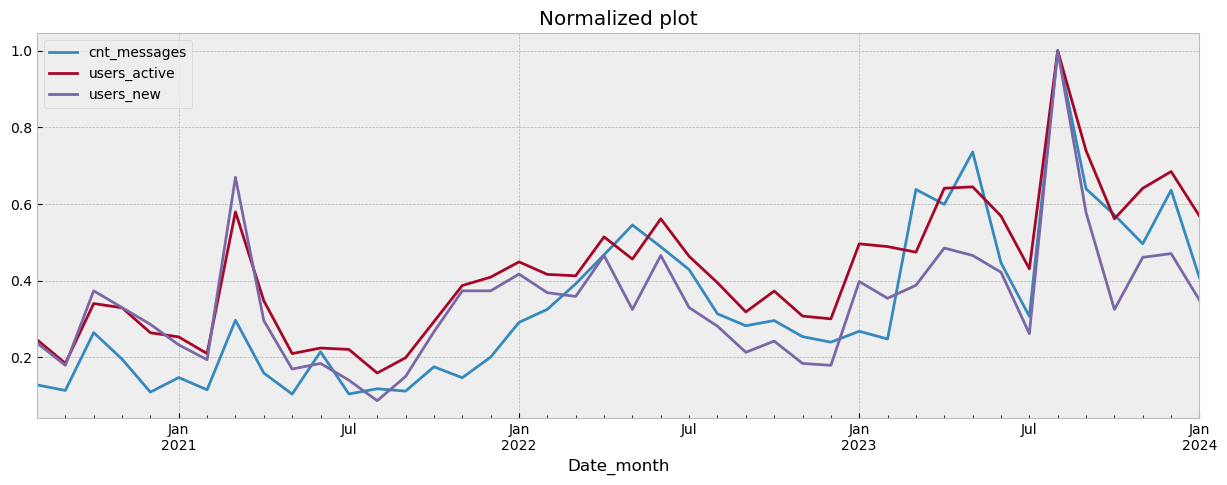

In [117]:
_ = df_all.apply(lambda x: x/max(x)).plot(figsize = (15,5), title = 'Normalized plot')

### 1. Stationarity

In [193]:
x = df_all['cnt_messages']
# x = df_all['users_new']
# x = df_all['users_active']

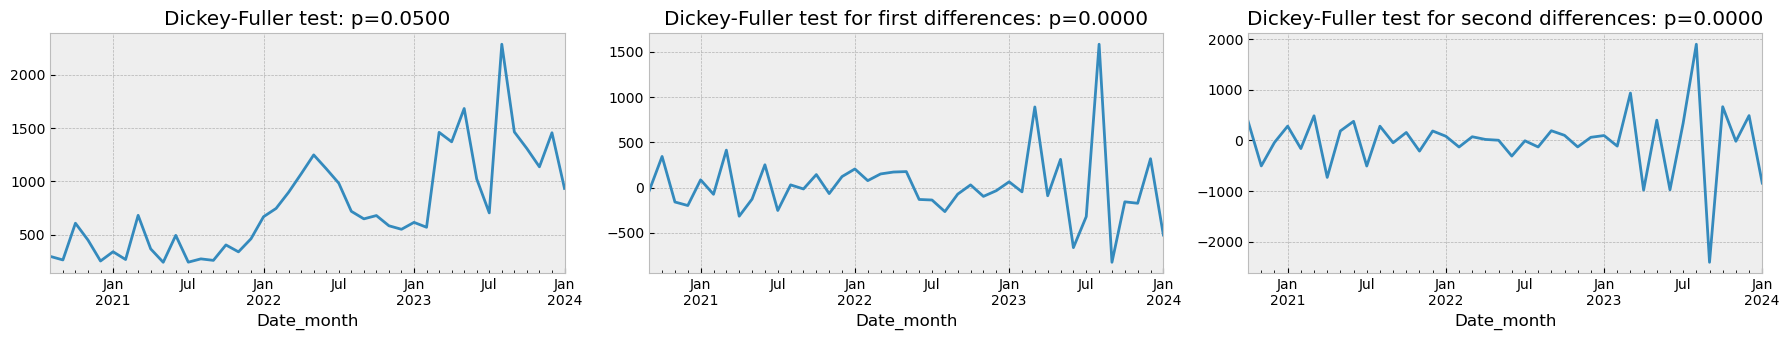

In [194]:
# Dickey — Fuller test
_, ax = plt.subplots(1,3, figsize = (18,3.5))
x1 = x
test_res = sm.tsa.stattools.adfuller(x1)
t = f"Dickey-Fuller test: p={test_res[1]:.4f}"# {test_res[0]:.4f}"
_ = x1.plot(title = t, ax = ax[0])

x1 = x.diff(1)[1:]
test_res = sm.tsa.stattools.adfuller(x1)
t = f"Dickey-Fuller test for first differences: p={test_res[1]:.4f}"# {test_res[0]:.4f}"
_ = x1.plot(title = t, ax = ax[1])

x1 = x.diff(1).diff(1)[2:]
test_res = sm.tsa.stattools.adfuller(x1)
t = f"Dickey-Fuller test for second differences: p={test_res[1]:.4f}"# {test_res[0]:.4f}"
_ = x1.plot(title = t, ax = ax[2])
plt.tight_layout()

### 2. ACF, PACF

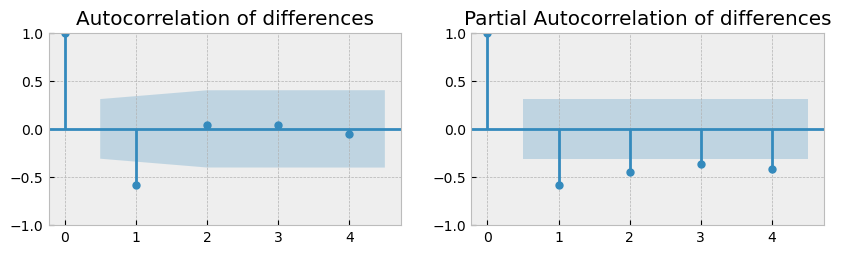

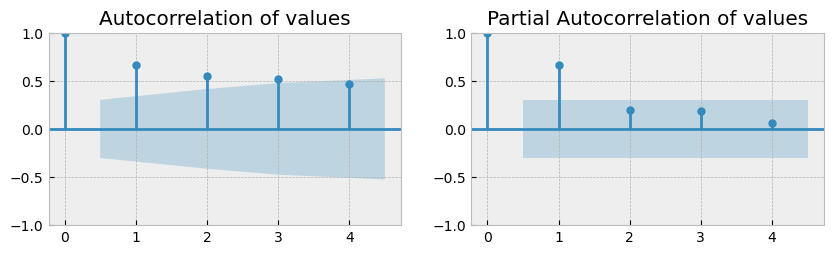

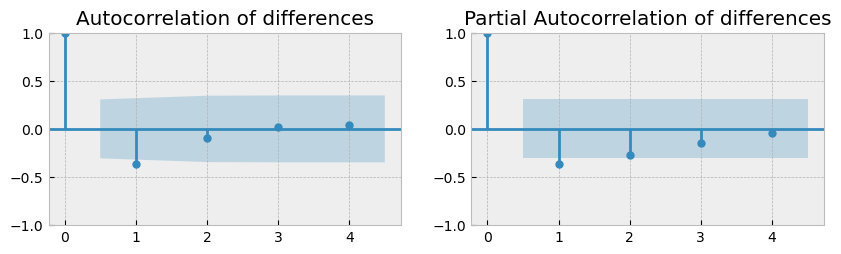

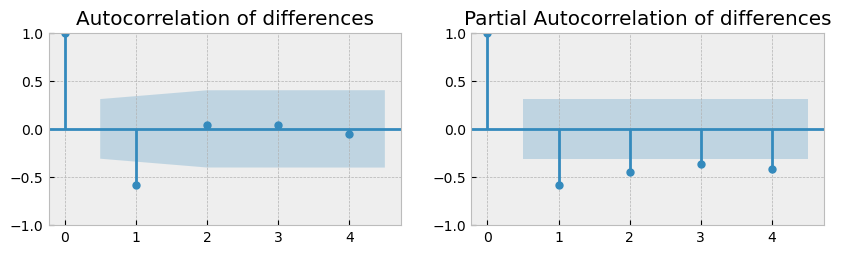

In [163]:
# Посмотрим на ACF и PACF полученного ряда:
l = 4
_, ax = plt.subplots(1,2, figsize = (10,2.5))
sm.graphics.tsa.plot_acf( x, lags=l, ax = ax[0], title = 'Autocorrelation of values')
sm.graphics.tsa.plot_pacf(x, lags=l, ax = ax[1], title = 'Partial Autocorrelation of values')

x1 = x.diff(1)[1:]
_, ax = plt.subplots(1,2, figsize = (10,2.5))
sm.graphics.tsa.plot_acf( x1, lags=l, ax = ax[0], title = 'Autocorrelation of differences')
sm.graphics.tsa.plot_pacf(x1, lags=l, ax = ax[1], title = 'Partial Autocorrelation of differences')

x1 = x.diff(1).diff(1)[2:]
_, ax = plt.subplots(1,2, figsize = (10,2.5))
sm.graphics.tsa.plot_acf( x1, lags=l, ax = ax[0], title = 'Autocorrelation of differences')
sm.graphics.tsa.plot_pacf(x1, lags=l, ax = ax[1], title = 'Partial Autocorrelation of differences')


### 3. Modeling

In [195]:
n = len(x) # all periods
n1 = 5     # valid periods

In [196]:
# SARIMAX searching
ps = range(0, 4) # by partial autocorr
ds = range(0, 3)
qs = range(0, 4) # by autocorr

parameters = itertools.product(ps, ds, qs, [0], [0], [0], [0])
parameters_list = list(parameters)
print(len(parameters_list))

48


In [197]:
%%time
list_param = []
list_res   = []
list_time  = []
list_pred  = []
import gc
import time

for p in parameters_list:
    t1 = time.time()
    list_res1 = list()
    list_pred1 = list()
    # train-valid split
    for k in range(1):
        train, valid = x[:-n1], x[-n1:]
        
        # train
        try:
            model_arima = sm.tsa.statespace.SARIMAX(train, order=(p[0],p[1],p[2]), seasonal_order=(p[3],p[4],p[5],p[6]))
            model_arima = model_arima.fit(disp=-1)
        except Exception as e:
            print(p, e)
            break
            
        # predict
        pred = model_arima.predict(start = 0, end = n - 1)
        pred = pred[-n1:]
        list_pred1 += list(pred)
        
        # evaluate
        res = ts_metrics(valid, pred)
        list_res1.append(res)
        
        del model_arima
        gc.collect()
        
        # break
        
    # collect
    if len(list_pred1) > 0:
        list_pred.append(list_pred1)
        list_res.append(pd.DataFrame(list_res1).mean())
        list_time.append({'time':time.time() - t1})
        list_param.append(p)

CPU times: total: 1min 9s
Wall time: 15.4 s


In [198]:
# results
df_out = pd.concat([
    pd.DataFrame(list_param, columns = ['p','d','q','P','D','Q','S']),
    pd.DataFrame(list_res),
    pd.DataFrame(list_time),
], axis = 1).sort_values('mae')
del df_out['P']
del df_out['D']
del df_out['Q']
del df_out['S']
del df_out['time']
df_out.reset_index(inplace = True)
del df_out['index']
df_out[:10]

,p,d,q,mae,mape
0,2,0,3,234.69,0.22
1,2,0,2,267.46,0.25
2,0,1,3,293.09,0.23
3,1,0,1,298.14,0.27
4,1,0,3,298.17,0.22
5,3,0,0,302.37,0.27
6,2,1,2,312.84,0.30
7,1,0,2,331.46,0.29
8,1,1,3,333.61,0.31
9,3,1,2,344.52,0.31


In [201]:
# retrain best model
model_arima = sm.tsa.statespace.SARIMAX(x, order=(2,0,3), seasonal_order=(0,0,0,0))
model_arima = model_arima.fit(disp=-1)
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           cnt_messages   No. Observations:                   42
Model:               SARIMAX(2, 0, 3)   Log Likelihood                -304.097
Date:                Tue, 12 Mar 2024   AIC                            620.194
Time:                        15:20:27   BIC                            630.620
Sample:                    08-01-2020   HQIC                           624.015
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2529      0.104      2.442      0.015       0.050       0.456
ar.L2          0.7073      0.143      4.952      0.000       0.427       0.987
ma.L1          0.3472      0.346      1.005      0.315      -0.330       1.025
ma.L2         -0.5212      0.180     -2.902      0.004      -0.873      -0.169
ma.L3          0.1311      0.227      0.578      0.563      -0.314       0.576
sigma2      1.032e+05   3.85e-06   2.68e+10      0.000    1.03e+05    1.03e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                15.18
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              10.41   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.65e+26. Standard errors may be unstable.
"""

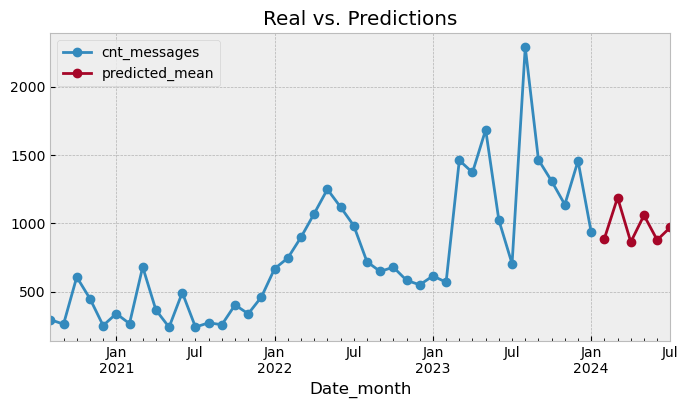

In [202]:
# make predictions
pred = model_arima.predict(start = 1, end = n + n1)
# pred.index = pred.index + 2010
_ = x.plot(figsize = (8,4), style = 'o-', legend = 'real', title = 'Real vs. Predictions')
_ = pred[-n1-1:].plot(figsize = (8,4), style = 'o-', legend = 'prediction')